# Read the output of a Geant4 PositronSource simulation

## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib ipympl
from matplotlib.ticker import AutoMinorLocator
import os
import uproot
import math
import re
from scipy import interpolate

from G4_utils import *
from G4_read_output_files import *

# Set the number of digits to show in pandas dataframes
pd.set_option('display.float_format', '{:.2f}'.format)

# tic
#import time
#start = time.time()

## Set input path and base filenames

In [2]:
path_conv = "/home/paterno/geant4-apps/PositronSource-build/output/conventional/"
name_conv = "output_6GeV_W2.0mm_noMesh"

path = "/home/paterno/geant4-apps/PositronSource-build/output/results_6GeV_sigma0.5mm_W_radiator2mm_D0cm_target6-12mm_gp/"
name = "output_6GeV_W2.0mm_D0cm_target10.0mm"

## save and export settings

In [3]:
# Figure save option
saveFigs = False

## Set output path

In [4]:
# Define the output folder
outpath = path + "analysis_output/"
if not os.path.exists(outpath):
    os.makedirs(outpath)

## Read the root file for the random (conventional) source

In [5]:
print("\nopening rf:", name_conv ,".root file ...")

rf_conv = uproot.open(path_conv + name_conv + ".root")
df_conv = rf_conv['scoring_ntuple'].arrays(library='pd')

df_conv_in_conv = df_conv[(df_conv.screenID == 0)].copy().drop(["screenID"], axis=1)
df_conv_out_conv = df_conv[(df_conv.screenID == 1)].copy().drop(["screenID"], axis=1)
del df_conv

df_ph_conv = df_conv_out_conv[(df_conv_out_conv.particle == "gamma")].copy()
df_pos_conv = df_conv_out_conv[(df_conv_out_conv.particle == "e+")].copy()
print('\nphotons:', df_ph_conv.shape[0])
print('gamma:', df_pos_conv.shape[0], '\n')

df_ph_conv["P"] = (df_ph_conv.px*df_ph_conv.px + df_ph_conv.py*df_ph_conv.py + df_ph_conv.pz*df_ph_conv.pz)**0.5 #MeV
df_pos_conv["P"] = (df_pos_conv.px*df_pos_conv.px + df_pos_conv.py*df_pos_conv.py + df_pos_conv.pz*df_pos_conv.pz)**0.5 #MeV 


opening rf: output_6GeV_W2.0mm_noMesh .root file ...

photons: 71640
gamma: 6168 



## Read the root file for the hybrid source

In [6]:
print("\nopening rf:", name ,".root file ...")

rf = uproot.open(path + name + ".root")
rf_content = [item.split(';')[0] for item in rf.keys()]
#print('rf_content:', rf_content)

#screenID: 2=after the Radiator (if used), 0=before the Converter, 1=after the Converter (or the single-crystal)
#particle: Geant4 particle name
#x,y are in [mm]
#px,py,pz are in [MeV/c]
#t is in [ns]
#branches = ["screenID", "particle", "x", "y", "px", "py", "pz", "t", "eventID"]
df = rf['scoring_ntuple'].arrays(library='pd')

if 'eventID' in df:
    Nevents = len(np.array(df.eventID.unique()))
else:
    Nevents = 1.e4
print("Nevents:", Nevents) #number of simulated events (primary particles)

df_rad_out = df[(df.screenID == 2)].copy().drop(["screenID"], axis=1)
df_conv_in = df[(df.screenID == 0)].copy().drop(["screenID"], axis=1)
df_conv_out = df[(df.screenID == 1)].copy().drop(["screenID"], axis=1)
#df_wrong = df[(df.screenID == -1)].copy().drop(["screenID"], axis=1)
del df

df_ph = df_conv_in[(df_conv_in.particle == "gamma")].copy()
df_pos = df_conv_out[(df_conv_out.particle == "e+")].copy()
print('\nphotons:', df_ph.shape[0])
print('gamma:', df_pos.shape[0], '\n')

df_ph["P"] = (df_ph.px*df_ph.px + df_ph.py*df_ph.py + df_ph.pz*df_ph.pz)**0.5 #MeV
df_pos["P"] = (df_pos.px*df_pos.px + df_pos.py*df_pos.py + df_pos.pz*df_pos.pz)**0.5 #MeV  


opening rf: output_6GeV_W2.0mm_D0cm_target10.0mm .root file ...
Nevents: 10000

photons: 291173
gamma: 154332 



### Import the required libraries

In [7]:
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

import succolib as sl #Mattia's package (install it with: pip install succolib)

### Set plot style ###
import mplhep as hep
import plot_settings as settings

style = settings.style #use this with "import plot_settings as settings"
style['figure.figsize'] = (style['figure.figsize'][0], 8.50) #manual tweak to figure height
plt.style.use(style)

### Plot the photon spectrum emitted by the Radiator crystal 

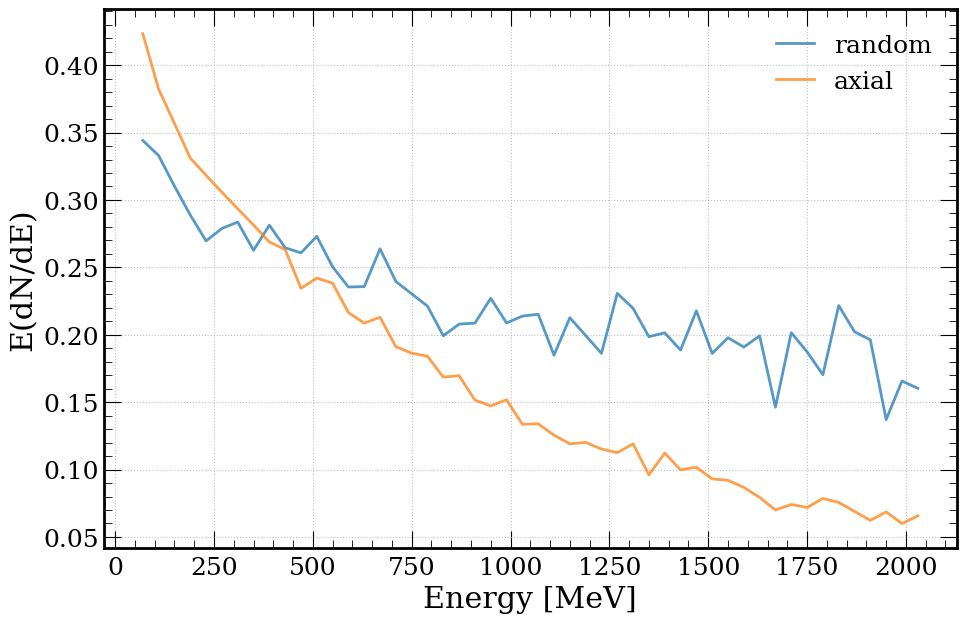

In [11]:
nbin_gamma = 50
range_gamma = (50, 2050)

spectrum_Eph_conv, edges_Eph = np.histogram(df_ph_conv.P, density=True, bins=nbin_gamma, range=range_gamma)
bin_Eph = edges_Eph[:-1] + (edges_Eph[1]-edges_Eph[0])*0.5
spectral_int_Eph_conv = spectrum_Eph_conv * bin_Eph

spectrum_Eph, _ = np.histogram(df_ph.P, density=True, bins=nbin_gamma, range=range_gamma)
spectral_int_Eph = spectrum_Eph * bin_Eph

fig = plt.figure(figsize=(11, 7))
fs = 16
lw = 2
opacity = 0.75
plt.plot(bin_Eph, spectral_int_Eph_conv, linewidth=lw, alpha=opacity, label='random')
plt.plot(bin_Eph, spectral_int_Eph, linewidth=lw, alpha=opacity, label='axial')
plt.legend()
plt.xlabel('Energy [MeV]')
#plt.ylabel('1/N$\\times$dN/dE')
plt.ylabel('1/N$\\times$E(dN/dE)')
plt.title('Emitted photons')
plt.grid(True)
#plt.yscale('log')
if saveFigs:
    plt.savefig(outpath + 'spectal_intensity_axial_random_' + purename + '.jpg')
plt.show()